In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



# PreProcessing Data

In [2]:

file_path = 'finalMergedData.csv'
df = pd.read_csv(file_path)

Delete the features that we are able to acess before the play starts, including passResult, passLength, penaltyYards, playNullifiedByPenalty, passPossibility

In [43]:
# Add features to delete
features_to_delete = ['passResult', 'passProbability','prePenaltyPlayResult', 'penaltyYards', 'playNullifiedByPenalty', 'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2', 'homeTeamWinProbabilityAdded', 'visitorTeamWinProbilityAdded','expectedPointsAdded', 'expectedPoints' ]
# Drop the unwanted features
df = df.drop(features_to_delete, axis=1)

In [44]:
# delete a few descriptive features:
Features_to_delete = ['playDescription', 'gameId', 'ballCarrierId', 'ballCarrierDisplayName', 'collegeName', 'Full Name', 'Team']
df = df.drop(Features_to_delete, axis=1)

In [45]:
# Combine all unique values from the relevant columns into one list
unique_teams = pd.unique(df[['possessionTeam', 'defensiveTeam', 'yardlineSide']].values.ravel('K'))

# Create a label encoder object
label_encoder = LabelEncoder()

# Fit the label encoder on the unique values
label_encoder.fit(unique_teams)

# Transform each column with the fitted label encoder
df['possessionTeam'] = label_encoder.transform(df['possessionTeam'])
df['defensiveTeam'] = label_encoder.transform(df['defensiveTeam'])
df['yardlineSide'] = label_encoder.transform(df['yardlineSide'])
df['offenseFormation'] = label_encoder.fit_transform(df['offenseFormation'])
df['Position'] = label_encoder.fit_transform(df['Position'])
df['playDirection'] = label_encoder.fit_transform(df['playDirection'])


def clock_to_minutes(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes
def height_to_cm(height):
    feet, inches = height.split('-')
    return int(feet) * 30.48 + int(inches) * 2.54
# Apply this function to each entry in the 'gameClock' column
df['gameClock'] = df['gameClock'].apply(clock_to_minutes)
df['height_x'] = df['height_x'].apply(height_to_cm)



In [46]:
df['defendersInTheBox'] = df['defendersInTheBox'].fillna(0)
df['passLength'] = df['passLength'].fillna(0)
# Check if any row has at least one missing value
# Check if any row has at least one missing value
rows_with_missing_values = df.isnull().any(axis=1)


playResult                          1.000000
passLength                          0.604894
Position                            0.335807
height_x                            0.140692
yardlineNumber                      0.101345
yardsToGo                           0.087221
down                                0.070271
yearsPro                            0.021484
age                                 0.017261
preSnapVisitorScore                 0.011401
preSnapHomeScore                    0.009242
preSnapVisitorTeamWinProbability    0.004350
possessionTeam                      0.003563
playId                              0.002399
defensiveTeam                       0.001868
yardlineSide                        0.000501
overall_rating                     -0.000409
playDirection                      -0.003481
quarter                            -0.003907
preSnapHomeTeamWinProbability      -0.004350
absoluteYardlineNumber             -0.007049
teamId                             -0.008330
x         

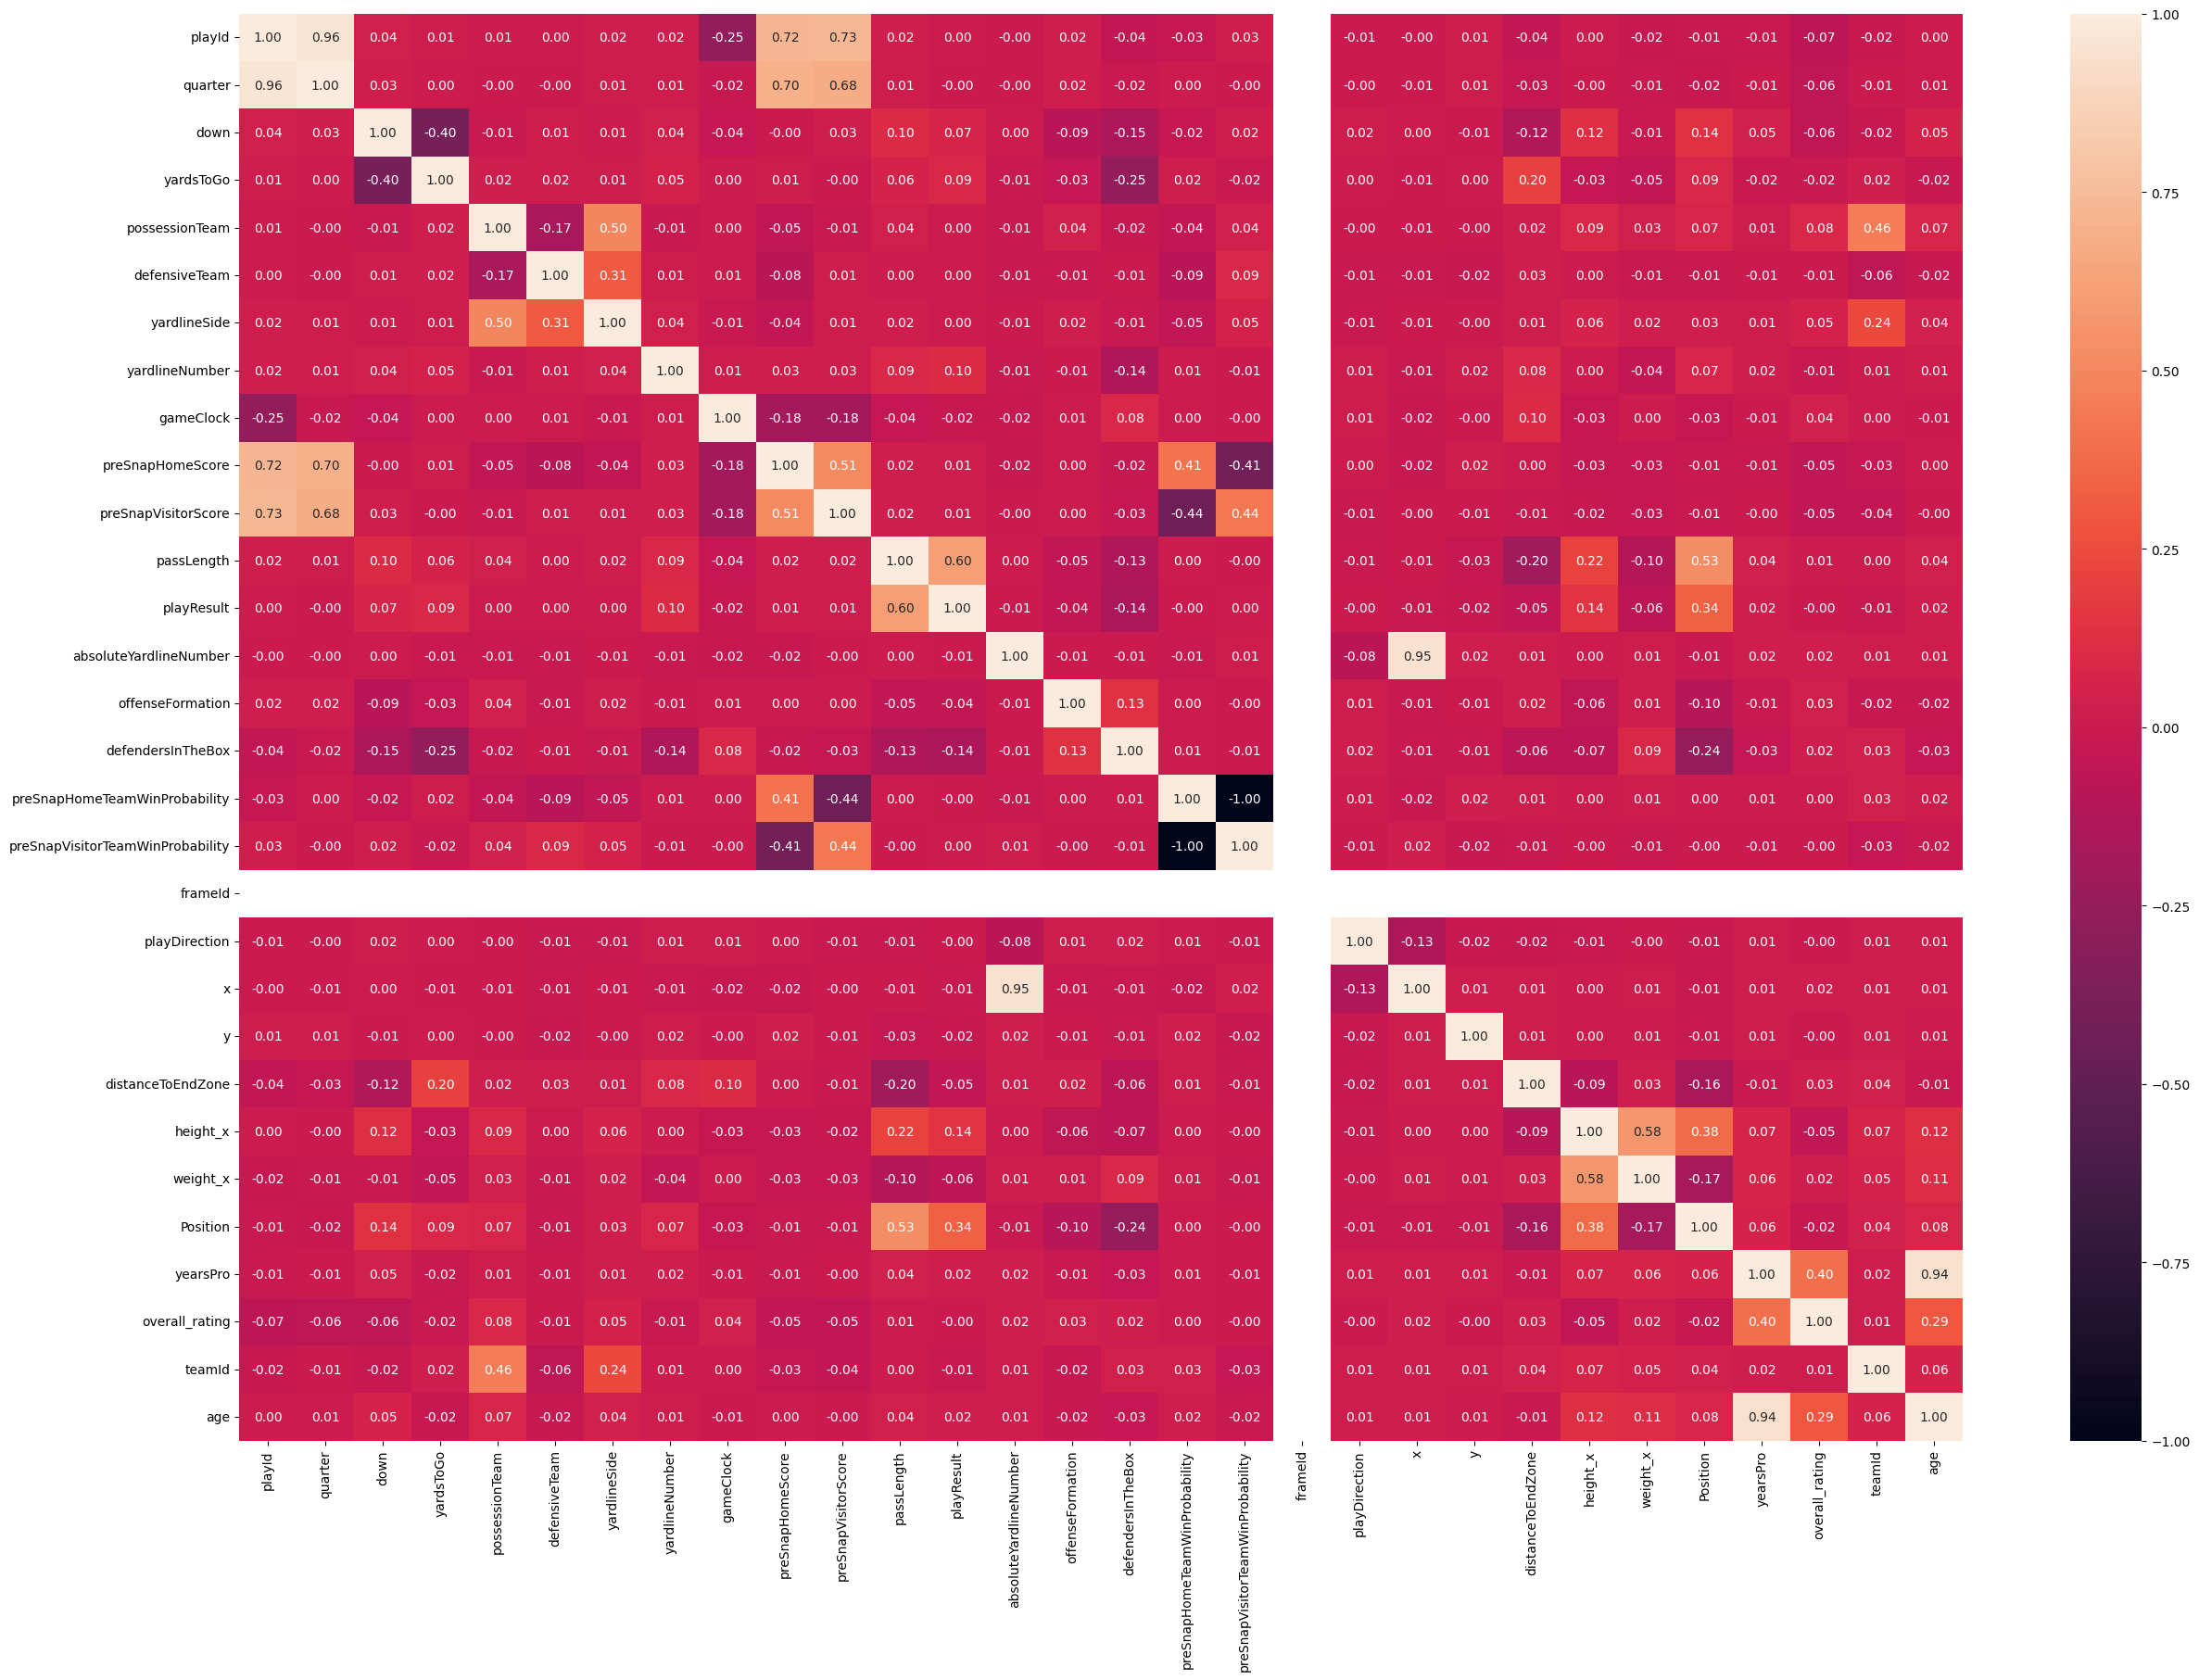

In [47]:
import pandas as pd
import seaborn as sns


# Assuming df is your DataFrame and 'playResult' is your target variable
X = df.drop('playResult', axis=1) # Features
y_final = df['playResult'] # Target variable
y_aux = df['passLength']

# Correlation analysis
correlation_matrix = df.corr()
print(correlation_matrix['playResult'].sort_values(ascending=False))
plt.figure(figsize=(30,20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()


In [48]:
# frameId is unrealeted, decide to delete it
df = df.drop('frameId', axis=1)

# Split data into trainig, validation and test sets

In [49]:

# Let's say you have y_aux as your auxiliary target (intermediary play result)
# and y_final as your final target to predict

# First, you split your data into training and a temporary set (combining validation and test)
X_train, X_temp, y_aux_train, y_aux_temp, y_final_train, y_final_temp = train_test_split(
    X, y_aux, y_final, test_size=0.4, random_state=42
)

# Now split the temporary set further into validation and test sets for both auxiliary and final targets
X_val, X_test, y_aux_val, y_aux_test, y_final_val, y_final_test = train_test_split(
    X_temp, y_aux_temp, y_final_temp, test_size=0.5, random_state=42
)


[[-1.43063404 -1.36168776  0.33507505 ...  1.59254814 -0.74487291
   0.1635413 ]
 [ 1.0767638   1.27494619  0.33507505 ... -0.87171136  0.99416637
  -0.60700745]
 [ 0.27903287  0.39606821  0.33507505 ... -0.87171136  1.75499605
  -1.3775562 ]
 ...
 [-1.27040604 -1.36168776 -0.91819841 ... -0.33600277  0.34202664
   0.54881567]
 [-1.37779289 -1.36168776  1.58834852 ... -1.51456166  0.99416637
  -1.3775562 ]
 [ 0.20744164 -0.48280978  1.58834852 ...  0.7354144  -0.31011309
  -0.22173308]]


# Set up model

In [55]:
#simplified model without tuning
def create_model(number_of_features, learning_rate, dropout_rate, activation):
    # Input layer
    inputs = Input(shape=(number_of_features,))
    x = inputs

    x = Dense(20, activation=activation)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(20, activation=activation)(x)
    x = Dropout(dropout_rate)(x)
    # Auxiliary output (assuming it's a regression task)
    auxiliary_output = Dense(1, name='aux_output')(x)
    x = Dense(20, activation=activation)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(20, activation=activation)(x)
    x = Dropout(dropout_rate)(x)

    # Main output (assuming it's a regression task)
    main_output = Dense(1, name='main_output')(x)

    # Define model
    model = Model(inputs=inputs, outputs=[main_output, auxiliary_output])

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss={'main_output': 'mean_squared_error', 'aux_output': 'mean_squared_error'},
                  loss_weights={'main_output': 1., 'aux_output': 0.4},
                  metrics={'main_output': 'mean_squared_error', 'aux_output': 'mean_squared_error'})

    return model


# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_main_output_loss',  # Monitor the validation loss of the main output
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Hyperparameters
model = create_model(
    number_of_features=X_train.shape[1],
    learning_rate=0.01,
    dropout_rate=0.0,
    activation='relu'
)

# Fit the model with the EarlyStopping callback
history = model.fit(
    X_train, [y_final_train, y_aux_train],
    validation_data=(X_val, [y_final_val, y_aux_val]),
    epochs=100,  # Set to a high value; EarlyStopping will determine the actual number
    batch_size=32,
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)

val_loss = np.mean(history.history['val_main_output_loss'])
print(f"Validation loss: {val_loss}")



Epoch 1/100
213/213 [==============================] - 2s 4ms/step - loss: 876.6987 - main_output_loss: 212.2367 - aux_output_loss: 1661.1555 - main_output_mean_squared_error: 212.2367 - aux_output_mean_squared_error: 1661.1555 - val_loss: 100.0811 - val_main_output_loss: 81.3832 - val_aux_output_loss: 46.7447 - val_main_output_mean_squared_error: 81.3832 - val_aux_output_mean_squared_error: 46.7447
Epoch 2/100
213/213 [==============================] - 1s 3ms/step - loss: 84.9861 - main_output_loss: 72.9281 - aux_output_loss: 30.1448 - main_output_mean_squared_error: 72.9281 - aux_output_mean_squared_error: 30.1448 - val_loss: 73.5274 - val_main_output_loss: 68.5918 - val_aux_output_loss: 12.3390 - val_main_output_mean_squared_error: 68.5918 - val_aux_output_mean_squared_error: 12.3390
Epoch 3/100
213/213 [==============================] - 1s 3ms/step - loss: 70.1538 - main_output_loss: 64.2010 - aux_output_loss: 14.8820 - main_output_mean_squared_error: 64.2010 - aux_output_mean_squa

In [ ]:
# with tuning
def create_model(number_of_features, learning_rate, n_layers, n_units, dropout_rate, activation):
    # Input layer
    inputs = Input(shape=(number_of_features,))
    x = inputs

    # Add hidden layers dynamically based on n_layers
    for i in range(n_layers):
        x = Dense(n_units, activation=activation)(x)
        x = Dropout(dropout_rate)(x)

    # Auxiliary output (assuming it's a regression task)
    auxiliary_output = Dense(1, name='aux_output')(x)

    # Additional layers leading to the main task (if needed)
    for i in range(n_layers):
        x = Dense(n_units, activation=activation)(x)
        x = Dropout(dropout_rate)(x)

    # Main output (assuming it's a regression task)
    main_output = Dense(1, name='main_output')(x)

    # Define model
    model = Model(inputs=inputs, outputs=[main_output, auxiliary_output])

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss={'main_output': 'mean_squared_error', 'aux_output': 'mean_squared_error'},
                  loss_weights={'main_output': 1., 'aux_output': 0.4},
                  metrics={'main_output': 'mean_squared_error', 'aux_output': 'mean_squared_error'})

    return model


# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_main_output_loss',  # Monitor the validation loss of the main output
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Hyperparameters
learning_rates = [0.001, 0.0001]
number_of_layers_options = [1, 2, 3]
units_options = [32, 64, 128]
dropout_rates = [0.0, 0.2]
activations = ['relu', 'tanh', 'sigmoid']

# Iterate over hyperparameters
for lr in learning_rates:
    for n_layers in number_of_layers_options:
        for n_units in units_options:
            for dropout_rate in dropout_rates:
                for activation in activations:
                    # Create and compile a new model
                    model = create_model(
                        number_of_features=X_train.shape[1],
                        learning_rate=lr,
                        n_layers=n_layers,
                        n_units=n_units,
                        dropout_rate=dropout_rate,
                        activation=activation
                    )

                    # Fit the model with the EarlyStopping callback
                    history = model.fit(
                        X_train, [y_final_train, y_aux_train],
                        validation_data=(X_val, [y_final_val, y_aux_val]),
                        epochs=100,  # Set to a high value; EarlyStopping will determine the actual number
                        batch_size=32,
                        callbacks=[early_stopping]  # Add the EarlyStopping callback here
                    )

                    # Evaluate the model using the validation set
                    val_loss = np.mean(history.history['val_main_output_loss'])
                    print(f"Validation loss with lr={lr}, n_layers={n_layers}, n_units={n_units}, dropout_rate={dropout_rate}, activation={activation}: {val_loss}")


